# 0. Imports

In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

from scipy.stats import mannwhitneyu, chi2_contingency
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMClassifier


plt.style.use("seaborn-v0_8")

In [2]:
# Funções

# Convertendo nomes das variáveis em snake_case
def to_snake_case(col_name):
    col_name = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", col_name)
    col_name = re.sub("([a-z0-9])([A-Z])", r"\1_\2", col_name)
    col_name = col_name.replace(" ", "_")
    return col_name.lower()

# Checando missing values
def missing_summary(df, sort=True):
    summary = (
        df.isna()
          .agg(["sum", "mean"])
          .T
          .reset_index()
          .rename(columns={
              "index": "variable",
              "sum": "missing_count",
              "mean": "missing_pct"
          })
    )

    summary["missing_pct"] = (summary["missing_pct"] * 100).round(2)

    if sort:
        summary = summary.sort_values("missing_pct", ascending=False)

    return summary

# 1. Entendimento do negócio

## 1.1. Contexto
Perder clientes é um dos principais problemas de empresas de telecomunicação - e de empresas no contexto geral, dado que o custo de adquirir novos clientes é maior que manter os clientes na carteira atual.

## 1.2. Objetivo
Dado este contexto, o objetivo deste projeto é identificar padrões de clientes que churnam a partir de suas características e, com isso, treinar um modelo preditivo que auxilie o negócio a implementar ações de retenção de clientes propensos ao churn.

# 2. Carregando os dados

In [3]:
# Check de caminho
os.getcwd()

'/Users/edneideramalho/Documents/repos/churn-project-end-to-end/notebooks'

In [4]:
df = pd.read_csv("../data/raw/telco_v2.csv") # volta dois níveis para acessar a pasta "data"
df.head()

,Customer ID,Gender,Age,Married,Dependents,Number of Dependents,Country,State,City,Zip Code,...,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Label,Churn Score,Churn Category,Churn Reason
0,8779-QRDMV,Male,78.0,No,no,0.0,United States,California,los angeles,90022.0,...,39.65,0.00,20.0,0.00,59.65,churned,yes,91.0,Competitor,Competitor offered more data
1,7495-OOKFY,female,74.0,yes,yes,1.0,UNITED STATES,California,Los Angeles,90063.0,...,633.30,0.00,0.0,390.80,1024.10,Churned,Yes,69.0,Competitor,Competitor made better offer
2,1658-bygoy,male,71.0,NO,yes,3.0,United States,california,Los Angeles,90065.0,...,8739.55,45.61,0.0,203.94,1910.88,Churned,Yes,81.0,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78.0,yes,Yes,1.0,UNITED STATES,California,Inglewood,90303.0,...,2514.50,13.43,0.0,494.00,2995.07,Churned,yes,88.0,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80.0,YES,YES,1.0,United States,California,WHITTIER,NaN,...,2868.15,0.00,0.0,234.21,3102.36,Churned,Yes,67.0,Price,Extra data charges


# 3. Visão geral dos dados

In [5]:
df.shape

(7043, 48)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7003 non-null   float64
 3   Married                            7043 non-null   object 
 4   Dependents                         7043 non-null   object 
 5   Number of Dependents               7009 non-null   float64
 6   Country                            7043 non-null   object 
 7   State                              7043 non-null   object 
 8   City                               7043 non-null   object 
 9   Zip Code                           7018 non-null   float64
 10  Latitude                           7008 non-null   float64
 11  Longitude                          7007 non-null   float

In [7]:
df.dtypes

Customer ID                           object
Gender                                object
Age                                  float64
Married                               object
Dependents                            object
Number of Dependents                 float64
Country                               object
State                                 object
City                                  object
Zip Code                             float64
Latitude                             float64
Longitude                            float64
Population                           float64
Quarter                               object
Referred a Friend                     object
Number of Referrals                  float64
Tenure in Months                     float64
Offer                                 object
Phone Service                         object
Avg Monthly Long Distance Charges    float64
Multiple Lines                        object
Internet Type                         object
Avg Monthl

In [8]:
df.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Avg Monthly GB Streaming Movies,Avg Monthly GB Streaming Music,Avg Monthly GB Streaming TV,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Score
count,7003.000000,7009.000000,7018.000000,7008.000000,7007.000000,7011.000000,7006.000000,7011.000000,7009.000000,7010.000000,7043.000000,7043.000000,7043.000000,7005.000000,7013.000000,7010.000000,7009.000000,7008.000000,7014.000000,7014.000000
mean,93.329716,58.220859,93536.683528,71.956739,-62.458888,22163.282556,45.994148,83.940807,72.133845,73.013980,0.429788,0.431634,0.417862,113.265496,2335.464536,58.971673,48.008275,789.642837,3089.030676,103.265469
std,543.182471,601.575489,1951.109064,476.081068,640.277834,21154.150823,519.690378,590.009467,562.238515,583.751484,0.864756,0.868509,0.850784,572.427272,2356.205392,605.528820,498.990015,974.146779,2916.963485,541.456957
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,11.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,21.360000,5.000000
25%,32.000000,0.000000,92108.000000,33.993991,-121.777179,2349.000000,0.000000,9.000000,9.330000,4.000000,0.000000,0.000000,0.000000,35.800000,407.050000,0.000000,0.000000,72.607500,619.702500,41.000000
50%,46.000000,0.000000,93531.000000,36.296851,-119.486225,17494.000000,0.000000,29.000000,23.180000,17.000000,0.000000,0.000000,0.000000,70.550000,1412.650000,0.000000,0.000000,413.370000,2160.355000,62.000000
75%,60.000000,0.000000,95345.000000,38.224869,-117.931698,36137.000000,3.000000,56.000000,36.710000,27.000000,0.000000,0.000000,0.000000,90.250000,3856.750000,0.000000,0.000000,1228.132500,4887.487500,76.000000
max,9905.000000,9550.000000,105423.000000,9848.893250,9874.797063,105285.000000,9943.000000,9915.000000,9692.350000,9634.000000,3.000000,3.000000,3.000000,10001.800000,16652.150000,9995.000000,9831.000000,10635.400000,18605.550000,9991.000000


In [9]:
# Vamos renomear as variáveis usando o snakecase
df_clean = df.copy()
df_clean.columns = [to_snake_case(col) for col in df_clean.columns]

# Removendo duplos `_`
df_clean.columns = (
    df_clean.columns
    .str.replace("__+", "_", regex=True)
    .str.strip("_")
)

df_clean.head()

,customer_id,gender,age,married,dependents,number_of_dependents,country,state,city,zip_code,...,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_label,churn_score,churn_category,churn_reason
0,8779-QRDMV,Male,78.0,No,no,0.0,United States,California,los angeles,90022.0,...,39.65,0.00,20.0,0.00,59.65,churned,yes,91.0,Competitor,Competitor offered more data
1,7495-OOKFY,female,74.0,yes,yes,1.0,UNITED STATES,California,Los Angeles,90063.0,...,633.30,0.00,0.0,390.80,1024.10,Churned,Yes,69.0,Competitor,Competitor made better offer
2,1658-bygoy,male,71.0,NO,yes,3.0,United States,california,Los Angeles,90065.0,...,8739.55,45.61,0.0,203.94,1910.88,Churned,Yes,81.0,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78.0,yes,Yes,1.0,UNITED STATES,California,Inglewood,90303.0,...,2514.50,13.43,0.0,494.00,2995.07,Churned,yes,88.0,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80.0,YES,YES,1.0,United States,California,WHITTIER,NaN,...,2868.15,0.00,0.0,234.21,3102.36,Churned,Yes,67.0,Price,Extra data charges


# 4. Qualidade dos dados

## 4.1. Excluindo variáveis


- Algumas variáveis foram removidas devido ao data leakage (como o churn_score), alta cardinalidade, ou interpretabilidade limitada devido ao seu formato. 
- Dados geográficos foram intencionalmente removidos neste estágio, com a opção de serem reintroduzidos num próximo ciclo, onde podemos trazer variáveis regionais.

In [10]:
cols_to_drop = [
    "churn_score",          # data leakage
    "zip_code",             # high cardinality / low interpretability
    "latitude",             # raw geographic info
    "longitude",             # raw geographic info
    "churn_category", 
    "churn_reason",
    "customer_status"
]

df_model = df_clean.drop(columns=cols_to_drop)
df_model.head()

,customer_id,gender,age,married,dependents,number_of_dependents,country,state,city,population,...,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,churn_label
0,8779-QRDMV,Male,78.0,No,no,0.0,United States,California,los angeles,68701.0,...,Month-to-Month,yes,Bank Withdrawal,39.65,39.65,0.00,20.0,0.00,59.65,yes
1,7495-OOKFY,female,74.0,yes,yes,1.0,UNITED STATES,California,Los Angeles,55668.0,...,Month-to-Month,yes,credit card,80.65,633.30,0.00,0.0,390.80,1024.10,Yes
2,1658-bygoy,male,71.0,NO,yes,3.0,United States,california,Los Angeles,47534.0,...,Month-to-Month,Yes,bank withdrawal,95.45,8739.55,45.61,0.0,203.94,1910.88,Yes
3,4598-XLKNJ,Female,78.0,yes,Yes,1.0,UNITED STATES,California,Inglewood,27778.0,...,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0.0,494.00,2995.07,yes
4,4846-WHAFZ,Female,80.0,YES,YES,1.0,United States,California,WHITTIER,26265.0,...,Month-to-Month,yes,BANK WITHDRAWAL,76.50,2868.15,0.00,0.0,234.21,3102.36,Yes


## 4.2. Uniformizando as variáveis categóricas
Algumas variáveis categóricas possuem nomes com letras maiúsculas e minúsculas, gerando mais categorias que o esperado. Por exemplo: Male e male, que deveriam estar numa mesma categoria. Vamos checar corrigir isso deixando tudo em minúsculo, e substituindo espaços por "_". 

In [11]:
# Identificando variáveis categóricas
categorical_cols = df_model.select_dtypes(include="object").columns
categorical_cols = categorical_cols.drop("customer_id")

# colocando as categorias em minuscula e removendo espaços se houver
for col in categorical_cols:
    df_model[col] = (
        df_model[col]
        .str.lower()
        .str.strip()
        .str.replace(" ", "_")
    )

df_model.head()

,customer_id,gender,age,married,dependents,number_of_dependents,country,state,city,population,...,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,churn_label
0,8779-QRDMV,male,78.0,no,no,0.0,united_states,california,los_angeles,68701.0,...,month-to-month,yes,bank_withdrawal,39.65,39.65,0.00,20.0,0.00,59.65,yes
1,7495-OOKFY,female,74.0,yes,yes,1.0,united_states,california,los_angeles,55668.0,...,month-to-month,yes,credit_card,80.65,633.30,0.00,0.0,390.80,1024.10,yes
2,1658-bygoy,male,71.0,no,yes,3.0,united_states,california,los_angeles,47534.0,...,month-to-month,yes,bank_withdrawal,95.45,8739.55,45.61,0.0,203.94,1910.88,yes
3,4598-XLKNJ,female,78.0,yes,yes,1.0,united_states,california,inglewood,27778.0,...,month-to-month,yes,bank_withdrawal,98.50,2514.50,13.43,0.0,494.00,2995.07,yes
4,4846-WHAFZ,female,80.0,yes,yes,1.0,united_states,california,whittier,26265.0,...,month-to-month,yes,bank_withdrawal,76.50,2868.15,0.00,0.0,234.21,3102.36,yes


In [12]:
# Padronizando as variáveis categóricas
cat_summary = pd.DataFrame({
    "variable": categorical_cols,
    "n_unique": [df_model[col].nunique() for col in categorical_cols],
    "most_frequent": [df_model[col].mode()[0] for col in categorical_cols]
})

cat_summary

,variable,n_unique,most_frequent
0,gender,2,male
1,married,2,no
2,dependents,2,no
3,country,1,united_states
4,state,1,california
5,city,1106,los_angeles
6,quarter,1,q3
7,referred_a_friend,2,no
8,offer,6,none
9,phone_service,2,yes


## 4.3. Missing Values

In [13]:
missing_summary(df_model)


,variable,missing_count,missing_pct
14,offer,2538.0,36.04
18,internet_type,964.0,13.69
2,age,40.0,0.57
34,monthly_charge,38.0,0.54
12,number_of_referrals,37.0,0.53
38,total_long_distance_charges,35.0,0.50
5,number_of_dependents,34.0,0.48
37,total_extra_data_charges,34.0,0.48
16,avg_monthly_long_distance_charges,34.0,0.48
36,total_refunds,33.0,0.47


- Algumas variáveis tem valores faltantes, com um baixo percentual, outras com alto percentual. Vamos decidir quais permanecem na análise e quais saem. E das que permancem, como faremos a imputação de NAs nos passos a seguir. 

## 4.4. Checando dados duplicados

In [14]:
# Checando dados duplicados
df_clean.duplicated().sum()

np.int64(0)

In [15]:
# Checando se há customer_id duplicado (esperamos uma linha por costumer)
df_clean["customer_id"].duplicated().sum()


np.int64(0)

- Não há dados duplicados na nossa base. 

# 5. Análise univariada

## 5.1. Variáveis Numéricas

In [16]:
num_cols = df_model.select_dtypes(include=["int64", "float64"]).columns
num_cols

Index(['age', 'number_of_dependents', 'population', 'number_of_referrals',
       'tenure_in_months', 'avg_monthly_long_distance_charges',
       'avg_monthly_gb_download', 'avg_monthly_gb_streaming_movies',
       'avg_monthly_gb_streaming_music', 'avg_monthly_gb_streaming_tv',
       'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue'],
      dtype='object')

### 5.1.1. Estatísticas descritivas

In [17]:
num_summary = (
    df_model[num_cols]
        .describe()
        .T
)

num_summary

,count,mean,std,min,25%,50%,75%,max
age,7003.0,93.329716,543.182471,19.00,32.0000,46.000,60.0000,9905.00
number_of_dependents,7009.0,58.220859,601.575489,0.00,0.0000,0.000,0.0000,9550.00
population,7011.0,22163.282556,21154.150823,11.00,2349.0000,17494.000,36137.0000,105285.00
number_of_referrals,7006.0,45.994148,519.690378,0.00,0.0000,0.000,3.0000,9943.00
tenure_in_months,7011.0,83.940807,590.009467,1.00,9.0000,29.000,56.0000,9915.00
avg_monthly_long_distance_charges,7009.0,72.133845,562.238515,0.00,9.3300,23.180,36.7100,9692.35
avg_monthly_gb_download,7010.0,73.013980,583.751484,0.00,4.0000,17.000,27.0000,9634.00
avg_monthly_gb_streaming_movies,7043.0,0.429788,0.864756,0.00,0.0000,0.000,0.0000,3.00
avg_monthly_gb_streaming_music,7043.0,0.431634,0.868509,0.00,0.0000,0.000,0.0000,3.00
avg_monthly_gb_streaming_tv,7043.0,0.417862,0.850784,0.00,0.0000,0.000,0.0000,3.00


- Neste sumário vemos valores que são claramente erros estruturais nos dados, como por exemplo, idade máxima de 9905, e o mesmo valor para number_of_dependents. Talvez tenha sido uma forma de codificar dados sem informação (NA).

In [18]:
# Visualizando os 5 valores mais altos em cada variável numérica
for col in num_cols:
    print(col, sorted(df_model[col].dropna().unique())[-5:])

age [np.float64(9264.0), np.float64(9273.0), np.float64(9617.0), np.float64(9761.0), np.float64(9905.0)]
number_of_dependents [np.float64(8644.0), np.float64(9237.0), np.float64(9490.0), np.float64(9497.0), np.float64(9550.0)]
population [np.float64(101215.0), np.float64(101906.0), np.float64(103214.0), np.float64(104224.0), np.float64(105285.0)]
number_of_referrals [np.float64(8544.0), np.float64(9309.0), np.float64(9336.0), np.float64(9444.0), np.float64(9943.0)]
tenure_in_months [np.float64(9183.0), np.float64(9325.0), np.float64(9388.0), np.float64(9778.0), np.float64(9915.0)]
avg_monthly_long_distance_charges [np.float64(9292.99), np.float64(9305.71), np.float64(9475.66), np.float64(9604.42), np.float64(9692.35)]
avg_monthly_gb_download [np.float64(9245.0), np.float64(9265.0), np.float64(9421.0), np.float64(9583.0), np.float64(9634.0)]
avg_monthly_gb_streaming_movies [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
avg_monthly_gb_streaming_music [np.int64(0), np.int64(1), np.i

> Valores acima de um limite plausível serão tratados como missing values, porque eles claramente representam valores incoerentes ou codificados como NA de maneira numérica.

- Regras que vamos usar para substituir esses valores:
    - `age`: 100,
    - `number_of_dependents`: 10,
    - `number_of_referrals`: 20
    - `tenure_in_months`: 120,
    - `monthly_charge`: 500,
    - `avg_monthly_long_distance_charges`: 500,
    - `avg_monthly_gb_download`: 1000,
    - `total_refunds`: 2000,
    - `total_extra_data_charges`: 2000

In [19]:
invalid_thresholds = {
    "age": 120,
    "number_of_dependents": 10,
    "number_of_referrals": 20,
    "tenure_in_months": 120,
    "monthly_charge": 500,
    "avg_monthly_long_distance_charges": 500,
    "avg_monthly_gb_download": 1000,
    "total_refunds": 2000,
    "total_extra_data_charges": 2000
}

df_model_corrected = df_model.copy()

for col, max_valid in invalid_thresholds.items():
    df_model_corrected.loc[
        df_model_corrected[col] > max_valid, col
    ] = np.nan

In [20]:
# Checando o sumário novamente 
num_cols = df_model_corrected.select_dtypes(include=["int64", "float64"]).columns

num_summary = (
    df_model_corrected[num_cols]
        .describe()
        .T
)

num_summary

,count,mean,std,min,25%,50%,75%,max
age,6934.0,46.495673,16.749034,19.00,32.0000,46.000,60.0000,80.00
number_of_dependents,6931.0,0.469341,0.963567,0.00,0.0000,0.000,0.0000,9.00
population,7011.0,22163.282556,21154.150823,11.00,2349.0000,17494.000,36137.0000,105285.00
number_of_referrals,6938.0,1.950130,3.000186,0.00,0.0000,0.000,3.0000,11.00
tenure_in_months,6945.0,32.448092,24.544460,1.00,9.0000,29.000,55.0000,72.00
avg_monthly_long_distance_charges,6940.0,22.984027,15.601542,0.00,9.2200,22.890,36.3900,208.90
avg_monthly_gb_download,6945.0,20.860331,26.201454,0.00,3.0000,17.000,27.0000,815.00
avg_monthly_gb_streaming_movies,7043.0,0.429788,0.864756,0.00,0.0000,0.000,0.0000,3.00
avg_monthly_gb_streaming_music,7043.0,0.431634,0.868509,0.00,0.0000,0.000,0.0000,3.00
avg_monthly_gb_streaming_tv,7043.0,0.417862,0.850784,0.00,0.0000,0.000,0.0000,3.00


- Agora os valores estão mais plausíveis e condizentes com a realidade.
- Temos que checar novamente os NAs e definir se serão excluídos ou imputados.

In [21]:
missing_summary(df_model_corrected)

,variable,missing_count,missing_pct
14,offer,2538.0,36.04
18,internet_type,964.0,13.69
5,number_of_dependents,112.0,1.59
2,age,109.0,1.55
12,number_of_referrals,105.0,1.49
34,monthly_charge,105.0,1.49
16,avg_monthly_long_distance_charges,103.0,1.46
36,total_refunds,99.0,1.41
19,avg_monthly_gb_download,98.0,1.39
13,tenure_in_months,98.0,1.39


- Vamos imputar valores NA das variáveis numéricas com a mediana:

In [22]:
df_imputed = df_model_corrected.copy()

for col in num_cols:
    median_value = df_imputed[col].median()
    df_imputed[col] = df_imputed[col].fillna(median_value)

# Checando novamente os missing values:
missing_summary(df_imputed)

,variable,missing_count,missing_pct
14,offer,2538.0,36.04
18,internet_type,964.0,13.69
2,age,0.0,0.00
1,gender,0.0,0.00
4,dependents,0.0,0.00
5,number_of_dependents,0.0,0.00
6,country,0.0,0.00
3,married,0.0,0.00
0,customer_id,0.0,0.00
8,city,0.0,0.00


- Gerando novamente as estatísticas descritivas corrigidas:

In [23]:
# Checando o sumário novamente 
num_cols = df_imputed.select_dtypes(include=["int64", "float64"]).columns

num_summary = (
    df_imputed[num_cols]
        .describe()
        .T
)

num_summary

,count,mean,std,min,25%,50%,75%,max
age,7043.0,46.488002,16.619015,19.00,33.000,46.000,59.000,80.00
number_of_dependents,7043.0,0.461877,0.957675,0.00,0.000,0.000,0.000,9.00
population,7043.0,22142.067585,21108.368367,11.00,2369.000,17494.000,36123.000,105285.00
number_of_referrals,7043.0,1.921056,2.987100,0.00,0.000,0.000,3.000,11.00
tenure_in_months,7043.0,32.400114,24.376422,1.00,9.000,29.000,55.000,72.00
avg_monthly_long_distance_charges,7043.0,22.982652,15.487028,0.00,9.405,22.890,36.175,208.90
avg_monthly_gb_download,7043.0,20.806616,26.022429,0.00,4.000,17.000,27.000,815.00
avg_monthly_gb_streaming_movies,7043.0,0.429788,0.864756,0.00,0.000,0.000,0.000,3.00
avg_monthly_gb_streaming_music,7043.0,0.431634,0.868509,0.00,0.000,0.000,0.000,3.00
avg_monthly_gb_streaming_tv,7043.0,0.417862,0.850784,0.00,0.000,0.000,0.000,3.00


## 5.2. Variáveis Categóricas

- Vamos imputar os NAs de algumas das variáveis categóricas de interesse
    - `offer`
    - `internet_type`

In [24]:
df_imputed_02 = df_imputed.copy()
categorical_cols = df_imputed_02.select_dtypes(include="object").columns

# Vamos imputar uma categoria explícita como "unknown"
for col in categorical_cols:
    df_imputed_02[col] = df_imputed_02[col].fillna("unknown")

In [25]:
# Checando NAs
missing_summary(df_imputed_02)

,variable,missing_count,missing_pct
0,customer_id,0.0,0.0
1,gender,0.0,0.0
2,age,0.0,0.0
3,married,0.0,0.0
4,dependents,0.0,0.0
5,number_of_dependents,0.0,0.0
6,country,0.0,0.0
7,state,0.0,0.0
8,city,0.0,0.0
9,population,0.0,0.0


In [26]:
# Sumário das variáveis
cat_summary = []

for col in categorical_cols:
    counts = df_imputed_02[col].value_counts(normalize=True) * 100
    values_with_pct = [
        f"{idx} ({pct:.1f}%)" for idx, pct in counts.items()
    ]

    cat_summary.append({
        "variable": col,
        "n_unique": df_imputed_02[col].nunique(),
        "categories_(%)": " | ".join(values_with_pct)
    })

cat_summary_df = pd.DataFrame(cat_summary)
cat_summary_df

,variable,n_unique,categories_(%)
0,customer_id,7043,8779-QRDMV (0.0%) | 7495-OOKFY (0.0%) | 1658-b...
1,gender,2,male (50.5%) | female (49.5%)
2,married,2,no (51.7%) | yes (48.3%)
3,dependents,2,no (76.9%) | yes (23.1%)
4,country,1,united_states (100.0%)
5,state,1,california (100.0%)
6,city,1106,los_angeles (4.2%) | san_diego (4.0%) | san_jo...
7,quarter,1,q3 (100.0%)
8,referred_a_friend,2,no (54.3%) | yes (45.7%)
9,offer,7,unknown (36.0%) | none (19.0%) | offer_b (11.7...


- Finalmente, resolvemos todos os problemas de valores faltantes e temos uma base limpa para os próximos passos. 
- Vemos os percentuais de distribuição para as variáveis categóricas. Algumas apresentam apenas um único valor como: country, state, quarter. Essas variáveis não vai acrescentar em nada em nosso modelo final, e, portanto, também serão removidas.

In [27]:
cols_to_drop = [
    "country",
    "state",
    "quarter"
]

df_imputed_02 = df_imputed_02.drop(columns=cols_to_drop)

## 5.3. Visualização

- Escolhemos somente duas variáveis que podem estar correlacionados com churn, para checar a distribuição. 
- Mais visualizações serão feitas nas análises bivariadas.

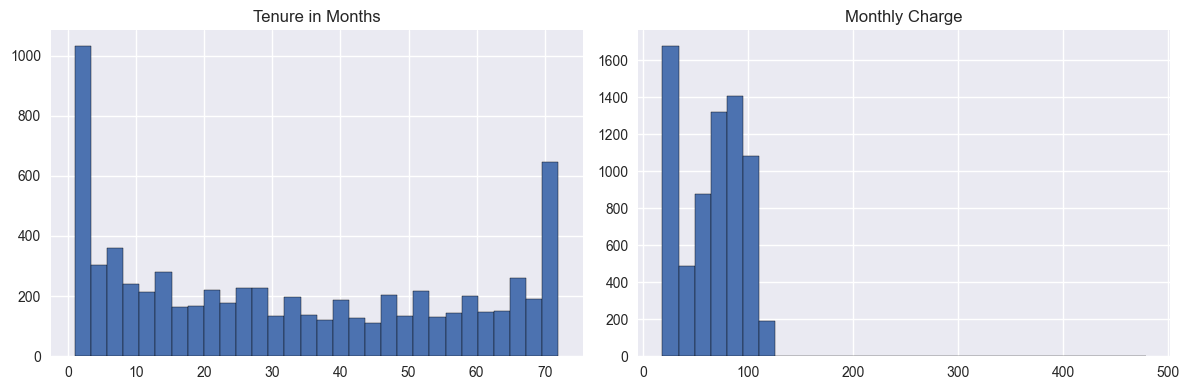

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_imputed_02["tenure_in_months"], bins=30, edgecolor="black")
axes[0].set_title("Tenure in Months")

axes[1].hist(df_imputed_02["monthly_charge"], bins=30, edgecolor="black")
axes[1].set_title("Monthly Charge")

plt.tight_layout()
plt.show()


# 6. Análises bivariadas

Para executar as análises bivariadas, algumas hipóteses serão levantadas.

## 6.1. Clientes com menor tempo de contrato têm maior probabilidade de churn. ✅

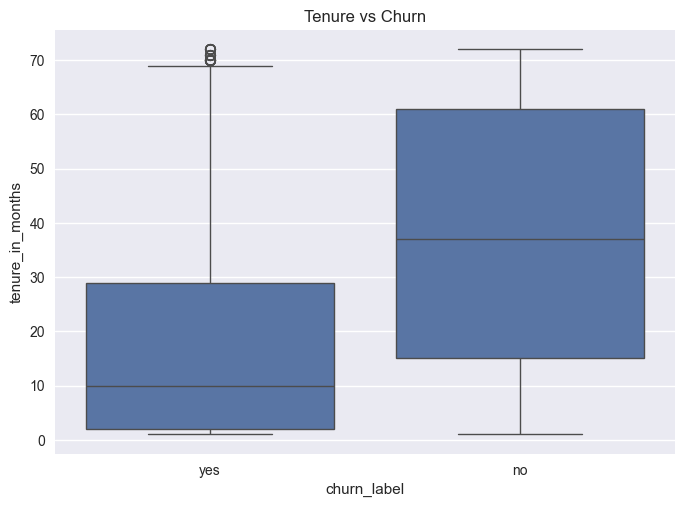

In [29]:
# Visualização
sns.boxplot(
    data=df_imputed_02,
    x="churn_label",
    y="tenure_in_months"
)
plt.title("Tenure vs Churn")
plt.show()

- Descritiva:

In [30]:
tenure_churn_summary = (
    df_imputed_02
        .groupby("churn_label")["tenure_in_months"]
        .agg(
            count="count",
            median="median",
            q1=lambda x: x.quantile(0.25),
            q3=lambda x: x.quantile(0.75)
        )
        .reset_index()
)

tenure_churn_summary


,churn_label,count,median,q1,q3
0,no,5174,37.0,15.0,61.0
1,yes,1869,10.0,2.0,29.0


In [31]:
# Teste estatístatico

churned = df_imputed_02.loc[df_imputed_02["churn_label"] == "yes", "tenure_in_months"]
not_churned = df_imputed_02.loc[df_imputed_02["churn_label"] == "no", "tenure_in_months"]


stat, p = mannwhitneyu(churned, not_churned, alternative="two-sided")

stat, p

(np.float64(2521870.5), np.float64(3.27814882795224e-207))

- Quem churna tem menos tempo de uso do serviço, ou seja, clientes em início de jornada costumam churnar. Os que permancem apresentam tempo de uso mediano de 37 meses (AIQ: 15-61 meses), enquanto os que churnam ficaram apenas 10 meses na mediana (AQI: 2-29 meses).
- Para confirmar se essa diferença foi estatisticamente significativa, foi aplicado o não paramétrico de Mann Whitney (p < 0,0001) mostrando que, de fato, a variável tenure é menor nos que churnam. 

## 6.2. Clientes com maior monthly charge tendem a churnar mais.

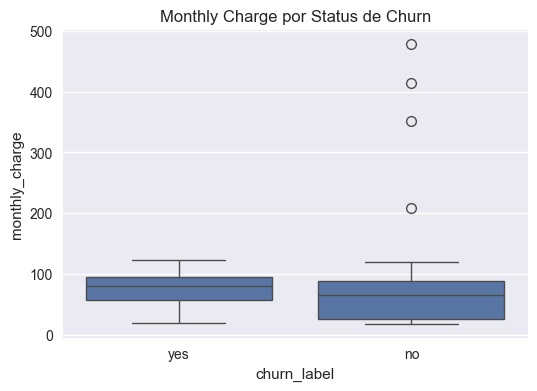

In [32]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_imputed_02,
    x="churn_label",
    y="monthly_charge"
)
plt.title("Monthly Charge por Status de Churn")
plt.show()

In [33]:
charge_churn_summary = (
    df_imputed_02
        .groupby("churn_label")["monthly_charge"]
        .agg(
            count="count",
            median="median",
            q1=lambda x: x.quantile(0.25),
            q3=lambda x: x.quantile(0.75)
        )
        .reset_index()
)

charge_churn_summary


,churn_label,count,median,q1,q3
0,no,5174,64.95,25.15,87.6875
1,yes,1869,79.40,57.45,94.1000


In [34]:
churned = df_imputed_02.loc[
    df_imputed_02["churn_label"] == "yes",
    "monthly_charge"
].dropna()

not_churned = df_imputed_02.loc[
    df_imputed_02["churn_label"] == "no",
    "monthly_charge"
].dropna()

stat, p = mannwhitneyu(
    churned,
    not_churned,
    alternative="greater"
)

stat, p

(np.float64(5995729.5), np.float64(7.592481937134605e-54))

- Clientes que pagam mais por mês tendem a cancelar mais. Vericamos que o valor mediano pago por aqueles que churnaram foi de \$ 79,40 (AIQ: 57.45-94.10), enquanto que o valor pago pelos que permaneceram foi de \$ 64,95 (AIQ: 25,15-87,69). 
- Embora essa diferença pareça pequena em termos absolutos, ela se mostrou estatisticamente significativa (Mann–Whitney U test, p < 0,0001). 

## 6.3. Clientes mais velhos apresentam maior churn.

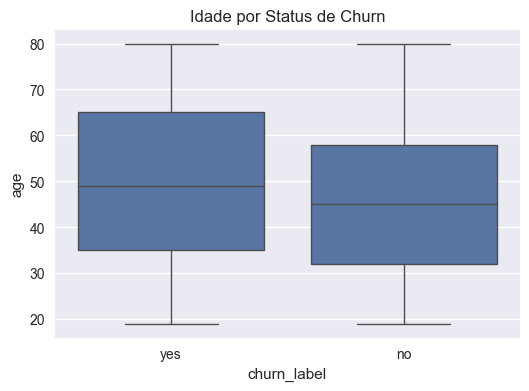

In [35]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_imputed_02,
    x="churn_label",
    y="age"
)
plt.title("Idade por Status de Churn")
plt.show()

In [36]:
age_churn_summary = (
    df_imputed_02
        .groupby("churn_label")["age"]
        .agg(
            count="count",
            median="median",
            q1=lambda x: x.quantile(0.25),
            q3=lambda x: x.quantile(0.75)
        )
        .reset_index()
)

age_churn_summary

,churn_label,count,median,q1,q3
0,no,5174,45.0,32.0,58.0
1,yes,1869,49.0,35.0,65.0


In [37]:
churned = df_imputed_02.loc[
    df_imputed_02["churn_label"] == "yes",
    "age"
].dropna()

not_churned = df_imputed_02.loc[
    df_imputed_02["churn_label"] == "no",
    "age"
].dropna()

stat, p = mannwhitneyu(
    churned,
    not_churned,
    alternative="greater"
)

stat, p

(np.float64(5515737.5), np.float64(8.172764763215102e-20))

- Existe uma diferença estatisticamente significativa na idade entre clientes que churnaram e os que não churnaram. A mediana de idade é MAIOR entre os clientes que churnaram (49 anos, AQI: 35-65). Os que não churnaram apresentam idade mediana de 45 anos (AIQ: 32-58).

## 6.4. Clientes casados churnam menos.

In [38]:
churn_marital = (
    pd.crosstab(
        df_imputed_02["married"],
        df_imputed_02["churn_label"],
        normalize="index"
    ) * 100
).round(2)

churn_marital

churn_label,no,yes
married,,
no,67.04,32.96
yes,80.34,19.66


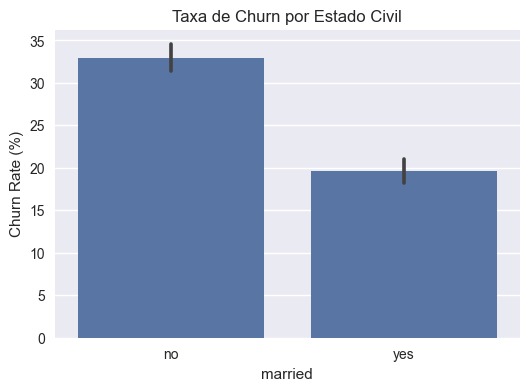

In [39]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=df_imputed_02,
    x="married",
    y=(df_imputed_02["churn_label"] == "yes").astype(int),
    estimator=lambda x: x.mean() * 100
)
plt.ylabel("Churn Rate (%)")
plt.title("Taxa de Churn por Estado Civil")
plt.show()

In [40]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(
    df_imputed_02["married"],
    df_imputed_02["churn_label"]
)

chi2, p, dof, expected = chi2_contingency(contingency_table)

chi2, p

(np.float64(158.7333820309922), np.float64(2.1399113440759935e-36))

- A proporção de pessoas que churnaram foi maior entre os não casados, aproximadamente 33%, enquanto que para os casados essa proporção foi de cerca de 20%.
- O teste do qui-quadrado indica uma associação estatisticamente significativa entre o estado civil e o churn (p < 0,001).

- Uma análise de correlação também pode ser usada como passo exploratório para avaliar possíveis multicolinearidades entre os atributos numéricos, antes de rodar o modelo baseline.

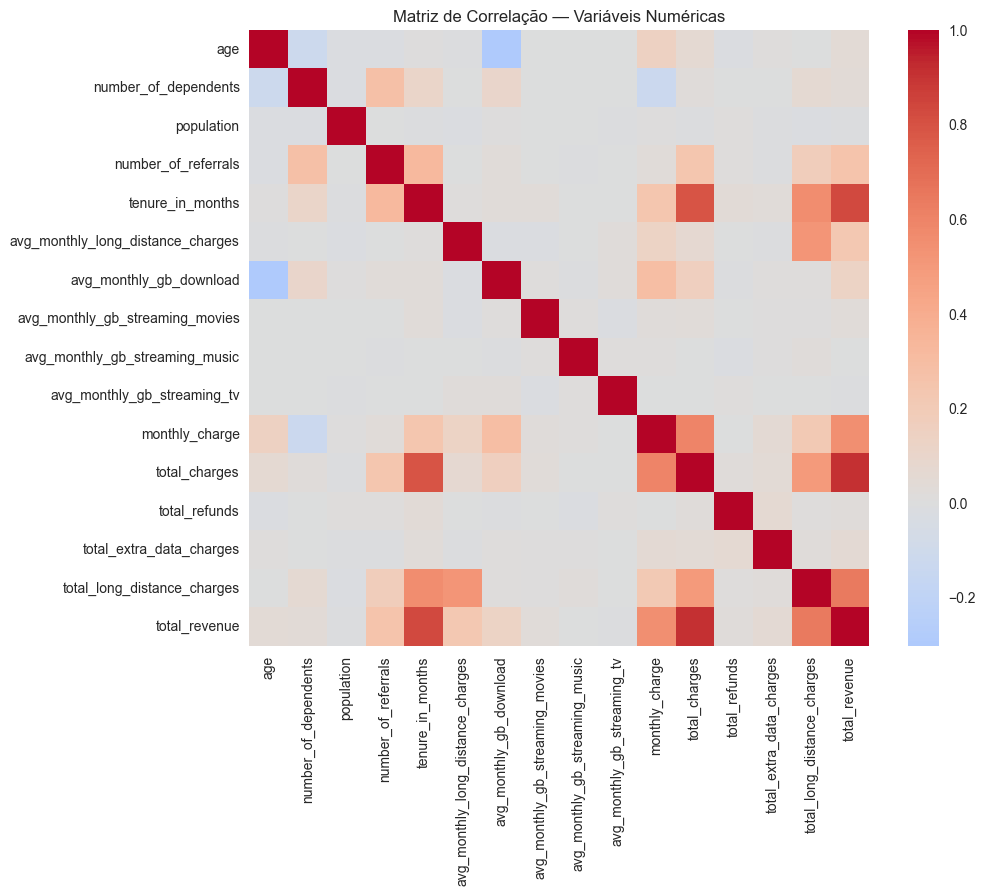

In [41]:
num_features = df_imputed_02.select_dtypes(include="number")

corr = num_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False
)
plt.title("Matriz de Correlação — Variáveis Numéricas")
plt.show()

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_num = num_features.dropna()

vif_df = pd.DataFrame({
    "feature": X_num.columns,
    "VIF": [variance_inflation_factor(X_num.values, i)
            for i in range(X_num.shape[1])]
})

(
    vif_df
        .sort_values("VIF", ascending=False)
        .reset_index(drop=True)
        .round(2)
)

,feature,VIF
0,total_revenue,20.60
1,total_charges,15.12
2,monthly_charge,11.16
3,tenure_in_months,10.71
4,age,6.84
5,avg_monthly_long_distance_charges,4.75
6,total_long_distance_charges,4.16
7,population,2.00
8,avg_monthly_gb_download,1.97
9,number_of_referrals,1.69


- Pelo heatmap de correlação entre váriáveis numéricas, podemos ver que algumas tem alta correlação entre si, pode gerar informações redundantes no modelo.
- Adicionalmente, foi calculado o VIF (Variance Inflation Factor) para as variáveis numéricas, e valores acima de 10 indicam alta colinearidade. 
- Dado este cenário, vamos remover do modelo baseline as variáveis: `total_revenue` e `total_charges` (que são variáveis  derivadas de outras: monthly_charge e tenure).
- Em relação a `tenure` e `monthly_charge`, podemos mantê-las num primeiro momento e, depois, testar varições de modelos com uma ou outra. 
- É importante lembrar que a multicolinearidade é menos crítica para modelos preditivos, mas afeta coeficientes de interpretabilidade, como no caso do nosso modelo baseline de Regressão Logística, daí a justificativa para o seu uso. 

# 7. Insights iniciais

- 💡 A maior concentração de churn ocorre nos primeiros meses de relacionamento, indicando um período crítico de retenção.
- 💡 Maiores cobranças mensais parecem estar associadas ao aumento de risco de churn, sugerindo que o preço pode desempenhar um papel importante na retenção do cliente. Isso destaca a importância de estratégias de preço e ofertas para clientes que pagam muito caro.
- 💡 Clientes mais velhos apresentam maior probabilidade de churn, indicando possíveis desafios de adequação dos serviços às necessidades desse grupo etário.
- 💡 Clientes casados apresentam menor taxa de churn, indicando maior estabilidade e maior comprometimento com o serviço.


# 8. Modelo inicial (baseline)

Vamos usar o modelo de **Regressão Logística** como nosso modelo baseline.

In [43]:
# Definindo o target
target = "churn"
df_final = df_imputed_02.copy()
df_final = df_final.rename(columns={"churn_label": "churn"})

In [44]:
df_final[target] = df_final[target].map({"yes": 1, "no": 0})
df_final.head()

,customer_id,gender,age,married,dependents,number_of_dependents,city,population,referred_a_friend,number_of_referrals,...,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,churn
0,8779-QRDMV,male,78.0,no,no,0.0,los_angeles,68701.0,no,0.0,...,month-to-month,yes,bank_withdrawal,39.65,39.65,0.00,20.0,0.00,59.65,1
1,7495-OOKFY,female,74.0,yes,yes,1.0,los_angeles,55668.0,yes,1.0,...,month-to-month,yes,credit_card,80.65,633.30,0.00,0.0,390.80,1024.10,1
2,1658-bygoy,male,71.0,no,yes,3.0,los_angeles,47534.0,no,0.0,...,month-to-month,yes,bank_withdrawal,95.45,8739.55,45.61,0.0,203.94,1910.88,1
3,4598-XLKNJ,female,78.0,yes,yes,1.0,inglewood,27778.0,yes,1.0,...,month-to-month,yes,bank_withdrawal,98.50,2514.50,13.43,0.0,494.00,2995.07,1
4,4846-WHAFZ,female,80.0,yes,yes,1.0,whittier,26265.0,yes,1.0,...,month-to-month,yes,bank_withdrawal,76.50,2868.15,0.00,0.0,234.21,3102.36,1


In [45]:
df_final.dtypes

customer_id                           object
gender                                object
age                                  float64
married                               object
dependents                            object
number_of_dependents                 float64
city                                  object
population                           float64
referred_a_friend                     object
number_of_referrals                  float64
tenure_in_months                     float64
offer                                 object
phone_service                         object
avg_monthly_long_distance_charges    float64
multiple_lines                        object
internet_type                         object
avg_monthly_gb_download              float64
online_security                       object
online_backup                         object
device_protection_plan                object
premium_tech_support                  object
streaming_tv                          object
streaming_

In [46]:
# Seleção de features
num_features = [
    "age",
    "monthly_charge",
    "tenure_in_months"
]

cat_features = [
    "gender",
    "married",
    "internet_type",
    "payment_method",
    "contract"
    ]

features = num_features + cat_features

In [47]:
X = df_final[features]
y = df_final[target]

In [48]:
# Split de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [49]:
# Encoding + Scaling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features)
    ]
)

In [50]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

In [51]:
model_lr = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", log_reg)
    ]
)

In [52]:
model_lr.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [ ]:
# Predições
y_pred_lr = model_lr.predict(X_test)
y_proba_lr = model_lr.predict_proba(X_test)[:, 1]

# Métricas Principais
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1035
           1       0.54      0.78      0.64       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.77      1409

ROC AUC: 0.853013511069777


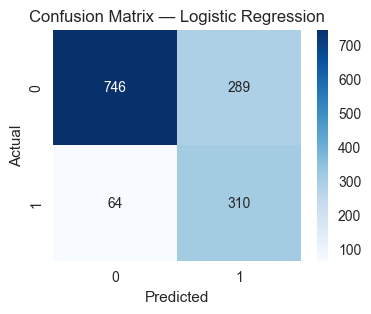

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

In [77]:
# Interpretação dos coeficientes
feature_names = (
    model_lr.named_steps["preprocessing"]
        .get_feature_names_out()
)

coefficients = model_lr.named_steps["model"].coef_[0]

coef_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefficients
    })
    .sort_values("coefficient", ascending=False)
)

coef_df


,feature,coefficient
6,cat__internet_type_fiber_optic,0.487888
10,cat__payment_method_mailed_check,0.388205
0,num__age,0.213255
1,num__monthly_charge,0.209991
3,cat__gender_male,0.008078
4,cat__married_yes,-0.089820
5,cat__internet_type_dsl,-0.306536
2,num__tenure_in_months,-0.526947
9,cat__payment_method_credit_card,-0.568808
8,cat__internet_type_unknown,-0.923990


- Resumo dos resultados do baseline:

| Métrica            | Valor    | Interpretação                                        |
| ------------------ | -------- | ---------------------------------------------------- |
| **Recall (churn)** | **0.83** | O modelo identifica **83% dos clientes que churnam** |
| Precision (churn)  | 0.52     | Cerca de metade dos alertas são churn real           |
| F1-score (churn)   | 0.64     | Bom equilíbrio para baseline                         |


- A tabela dos coeficientes mostram que:
    - Clientes com fibra óptica tendem a churnar mais,
    - Pagamento manual está associado a maior churn,
    - Clientes mais velhos tendem a churnar mais,
    - Quanto maior o valor mensal, maior o churn,
    - Clientes mais antigos churnam menos,
    - Pagamentos automáticos reduzem churn,
    - Sem internet → churn muito menor,
    - Contrato anual reduz churn,
    - Contrato longo é o maior fator protetivo (`contract_two_year`)


- O modelo baseline atinge um poder descriminatório forte, com alto recall para churn, fazendo com que seja uma boa ferramenta de alertas para antecipar churn e ser acionável na retenção de clientes.

> Como traduzir para o contexto de negócio?

**💡 Principais insights**

1. Clientes com contratos longos são muito menos propensos a churn

    Forte argumento para migração de contratos mensais → anuais

2. Tenure é um fator-chave de retenção

    Churn concentrado nos primeiros meses

3. Clientes com cobranças mais altas e fibra óptica exigem atenção

    Possível problema de percepção de valor ou qualidade

4. Forma de pagamento importa

    Pagamentos automáticos reduzem churn

# 9. Comparação de modelos

Além da Regressão Logística (baseline) vamos testar:

- Random Forest

- XGBoost

- LightGBM (ou Gradient Boosting se preferir evitar libs externas)


Esses modelos:

- Capturam não linearidades

- Lidam melhor com interações

- São padrão de mercado para churn

In [78]:
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features)
    ]
)


## 9.1. Radom forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42
)

model_rf = Pipeline(
    steps=[
        ("preprocessing", preprocessor_tree),
        ("model", rf)
    ]
)

model_rf.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [80]:
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1035
           1       0.54      0.78      0.64       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.77      1409

ROC AUC: 0.8580459324704848


## 9.2. XGBoost

In [61]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

model_xgb = Pipeline(
    steps=[
        ("preprocessing", preprocessor_tree),
        ("model", xgb)
    ]
)

model_xgb.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [81]:
y_pred_xgb = model_xgb.predict(X_test)
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1035
           1       0.69      0.57      0.62       374

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409

ROC AUC: 0.8676147665917486


## 9.3. LightGBM

In [67]:
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_lgbm = Pipeline(
    steps=[
        ("preprocessing", preprocessor_tree),
        ("model", lgbm)
    ]
)

In [68]:
model_lgbm.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [82]:
y_pred_lgbm = model_lgbm.predict(X_test)
y_proba_lgbm = model_lgbm.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lgbm))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lgbm))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC AUC: 0.8569660802397375


/Users/edneideramalho/Documents/repos/churn-project-end-to-end/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/edneideramalho/Documents/repos/churn-project-end-to-end/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 9.4. Comparação de modelos

In [92]:
from sklearn.metrics import recall_score, roc_auc_score

def evaluate_model(model_name, y_true, y_pred, y_proba):
    return {
        "model": model_name,
        "recall": round(recall_score(y_true, y_pred), 3),
        "roc_auc": round(roc_auc_score(y_true, y_proba),3)
    }

In [97]:
results = []

results.append(
    evaluate_model(
        "Logistic Regression",
        y_test,
        y_pred_lr,
        y_proba_lr
    )
)

results.append(
    evaluate_model(
        "Random Forest",
        y_test,
        y_pred_rf,
        y_proba_rf
    )
)

results.append(
    evaluate_model(
        "XGBoost",
        y_test,
        y_pred_xgb,
        y_proba_xgb
    )
)

results.append(
    evaluate_model(
        "LGBM",
        y_test,
        y_pred_lgbm,
        y_proba_lgbm
    )
)

results_df = pd.DataFrame(results).sort_values(
    by="roc_auc", ascending=False
)

results_df

,model,recall,roc_auc
2,XGBoost,0.567,0.868
1,Random Forest,0.783,0.858
3,LGBM,0.537,0.857
0,Logistic Regression,0.829,0.853


- Embora todos os modelos tem um ROC AUC alto, a **Regressão Logística** foi o modelo escolhido nesse ciclo pelo fato de apresentar um maior recall. No caso de churn o recall é importante porque o custo de um **falso negativo** é caro. É melhor dar um "desconto" (ou outro tipo de intervenção)  para quem já ia permanecer na empresa, do que perder um cliente para o qual não foi oferecida nenhuma intervenção. 

# 10. Novas variáveis propostas
- Quantidade de serviços contratados, por exemplo: `online_security`, `online_backup`,
       `device_protection_plan`, `premium_tech_support`, `streaming_tv`,
       `streaming_movies`, `streaming_music`. Podemos verificar se pessoas com mais serviços contratados teriam menor chance de churn.
- Usar análise de sentimentos usando NLP para dar um score de atendimento e reclamações. Clientes que entram em contato com suporte e não têm seus problemas analisados de forma correta, poderiam ter altas chances de churn. 
- Valor médio dos concorrentes: Uma métrica que compara o preço do plano do cliente com a oferta média atual dos concorrentes na mesma região (Zip Code).
- Alguma métrica de qualidade de serviço, como, por exemplo, quedas nas redes de telecomunicação, deixando o serviço fora de funcionamento ou oscilação constante de velocidades para certos locais. Isso pode gerar insastifação dos clientes, aumentando o risco de procurar um concorrente mais estável.


# 11. Testar as ações que a empresa já faz 

- Teste A/B a partir das ações do time de negócio, marketing por exemplo. 

# 12. Próximos passos

- Testar as outras variáveis que não foram inseridas nesse primeiro ciclo de modelagem e verificar se melhoraram a performance do modelo.
- Ajustar threshold para os modelos de XGBoost e LGBM para verificar se há alguma melhoria no recall. 
- Criar uma aplicação usando o Streamlit, por exemplo, onde o time de negócio subiria uma .csv com dados de clientes a serem testados e receberiam um arquivo com as probabilidades de churn de cada um deles. Com isso, conseguiriam priorizar ações para estes clientes e tentariam manter o contrato ativo.